# Rosenbrock toy distribution

This function (further described [here](http://pints.readthedocs.io/en/latest/toy/rosenbrock.html)) which can be used to define a normalisable probability density function:

$ p(x, y) \propto  \frac{1}{1 + \text{Rosenbrock}(x,y)}, $

that is,

$ p(x, y) \propto  \frac{1}{\left(1 + (1 - x)^2 + 100 (y - x^2)^2) \right)}, $

which we term the `RosenbrockLogPDF`.

We now plot this function.

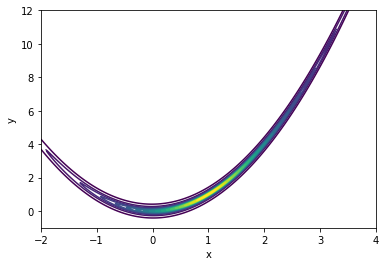

In [1]:
import os
os.chdir("../")
from __future__ import print_function
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import pints.plot

# Create Rosenbrock log pdf
log_pdf = pints.toy.RosenbrockLogPDF()

# Contour plot of pdf
levels = np.linspace(0, 1, 20)
x = np.linspace(-2, 4, 400)
y = np.linspace(-1, 12, 400)
X, Y = np.meshgrid(x, y)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, levels = levels)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Turn into Bayesian problem by using the inverse Rosenbrock function as a likelihood

Then use Hamiltonian Monte Carlo to sample from the posterior distribution

Running...
Using Hamiltonian MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0         0         0         0          0:00.0
2     164    0         0         0.25      0          0:00.0
3     244    0         0         0.4       0          0:00.0
20    1604   0.136     0.136     0.682     0.318      0:00.2
40    3204   0.31      0.119     0.667     0.238      0:00.3
60    4804   0.371     0.161     0.581     0.258      0:00.5
80    6404   0.451     0.183     0.512     0.244      0:00.6
100   8004   0.52      0.186     0.49      0.225      0:00.8
120   9604   0.582     0.189     0.5       0.213      0:00.9
140   11204  0.641     0.169     0.471831  0.254      0:01.1
160   12804  0.685     0.148     0.438     0.247      0:01.2
180   14404  0.665     0.143     0.44      0.236      0:01.4
200   16004  0.614     0.134     0.436     0.233      0:01.5
22

2560  204804  0.608509  0.331     0.603     0.397      0:19.7
2580  206404  0.605     0.334237  0.604     0.4        0:19.9
2600  208004  0.603     0.337     0.603     0.402      0:20.0
2620  209604  0.601     0.34      0.602     0.403      0:20.2
2640  211204  0.6       0.342922  0.603     0.405      0:20.4
2660  212804  0.599     0.343     0.602     0.404      0:20.5
2680  214404  0.6       0.345     0.602     0.405      0:20.7
2700  216004  0.603     0.346     0.6       0.407846   0:20.8
2720  217604  0.603     0.347     0.598     0.41       0:21.0
2740  219204  0.605     0.348     0.597     0.411      0:21.1
2760  220804  0.606     0.351     0.593     0.411      0:21.3
2780  222404  0.606     0.352     0.592739  0.411      0:21.5
2800  224004  0.603     0.354     0.593     0.411      0:21.6
2820  225604  0.6       0.358     0.59      0.411056   0:21.8
2840  227204  0.598874  0.359254  0.58867   0.413      0:21.9
2860  228804  0.598     0.36      0.585     0.413      0:22.1
2880  23

5240  419204  0.54      0.414918  0.55      0.522892   0:40.6
5260  420804  0.54      0.413     0.549     0.523      0:40.7
5280  422404  0.539     0.412     0.55      0.523476   0:40.9
5300  424004  0.538     0.410977  0.550547  0.523      0:41.0
5320  425604  0.537     0.41      0.551     0.524      0:41.2
5340  427204  0.535     0.40921   0.55      0.526      0:41.3
5360  428804  0.534     0.409     0.549     0.526      0:41.5
5380  430404  0.532     0.407841  0.547     0.526      0:41.6
5400  432004  0.531     0.406331  0.546     0.527      0:41.8
5420  433604  0.529     0.405201  0.544     0.527      0:42.0
5440  435204  0.528     0.404     0.544     0.527      0:42.1
5460  436804  0.527     0.403     0.542     0.528      0:42.3
5480  438404  0.525     0.402     0.541     0.53       0:42.4
5500  440004  0.524     0.402     0.539     0.531      0:42.6
5520  441604  0.522     0.401     0.538     0.532      0:42.7
5540  443204  0.521     0.399     0.537     0.533      0:42.9
5560  44

7920  633604  0.475     0.446     0.574     0.591      1:01.2
7940  635204  0.475447  0.446     0.574     0.592      1:01.4
7960  636804  0.476     0.445     0.574     0.592      1:01.5
7980  638404  0.477     0.445     0.574     0.593      1:01.7
8000  639924  0.477     0.444     0.574     0.594      1:01.8
Halting: Maximum number of iterations (8000) reached.
Done!
R-hat:
[1.2390804587375921, 1.0433722658973152]


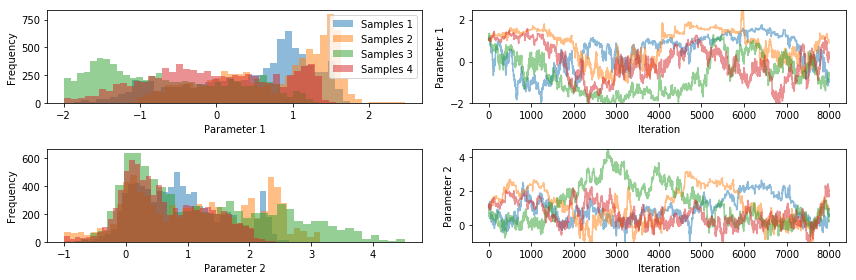

In [2]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([1, 1], [1.1, 1.1], size=(4, 2))
sigma0 = [0.05, 0.05]

# Use suggested prior bounds
bounds = log_pdf.suggested_bounds()

# Create a uniform prior over both the parameters
log_prior = pints.UniformLogPrior(
    bounds[0], bounds[1]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_pdf, log_prior)

mcmc = pints.MCMCSampling(log_posterior, 4, x0, method=pints.HamiltonianMCMC, sigma0=sigma0)

# Stop after 8000 iterations
mcmc.set_max_iterations(8000)

# Disable logging
# mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# Discard warm-up
chains = [chain[2000:] for chain in chains]

print('R-hat:')
print(pints.rhat_all_params(chains))

We inspect the results by creating a scatter plot of the samples. Hamiltonian Monte Carlo struggles to sample from this density since the optimal step size varies so much over the domain

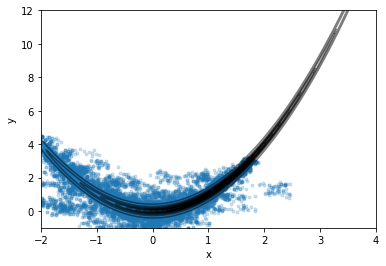

In [3]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-2, 4)
plt.ylim(-1, 12)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Plot the path of one of the chains

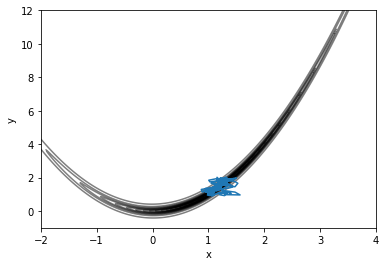

In [4]:
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.plot(chain[0:1000,0], chain[0:1000,1])
plt.xlim(-2, 4)
plt.ylim(-1, 12)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
log_pdf.distance(stacked)

10.373605883617742

In [22]:
import scipy.stats
test = scipy.stats.multivariate_normal([ex, ey], np.array([[varx, rho], [rho, vary]])).rvs(1000000)
np.mean(test, axis=0)
np.cov(np.transpose(test))
log_pdf.distance(test)

0.0066820489747055501

In [8]:
import scipy.integrate
denom = scipy.integrate.dblquad(lambda y, x: np.exp(log_pdf([x,y])), -2, 4, lambda x: -1, lambda x: 12)[0]
ex = scipy.integrate.dblquad(lambda y, x: x * np.exp(log_pdf([x,y])) / denom, -2, 4, lambda x: -1, lambda x: 12)[0]
ey = scipy.integrate.dblquad(lambda y, x: y * np.exp(log_pdf([x,y])) / denom, -2, 4, lambda x: -1, lambda x: 12)[0]
varx = scipy.integrate.dblquad(lambda y, x: (x - ex)**2 * np.exp(log_pdf([x,y])) / denom, -2, 4, lambda x: -1, lambda x: 12)[0]
vary = scipy.integrate.dblquad(lambda y, x: (y - ey)**2 * np.exp(log_pdf([x,y])) / denom, -2, 4, lambda x: -1, lambda x: 12)[0]
rho = scipy.integrate.dblquad(lambda y, x: (x - ex) * (y - ey) * np.exp(log_pdf([x,y])) / denom, -2, 4, lambda x: -1, lambda x: 12)[0]